# Notebook 26: Full SFR computation without dispersion

In this Notebook we reconsider the method porposed in Notebook 24, but this time we employ and update version of the code that allows us to fully map the space of valid redshift-metallicity pairs. We then compare them with the redshift-dependent metallicity distribution from Neijssel et al. (2019) in order to verify how limited we are.

#### Prelude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
import sys
sys.path.append('../src/')
sys.path.append('../legacy/')
from sfr_old import SFZR
from sampling import OSGIMF, save_osgimf_instance
from utils import sample_histogram, ZOH_from_FeH, FeH_to_Z, ZOH_to_FeH
from zdf import NeijsselZDF, MetallicityPicker
import constants as ct

#### The SFR grid and metallicity distribution

In [2]:
def zoh_limit(z, params):
    dz = params[-1]
    za = params[0]
    return za + dz*(z-3.5)

In [3]:
SFZRtest_z = np.linspace(0, 11, 50)
SFZRtest_FeH = np.linspace(-4, 1.5, 50) 
SFZRtest_ZOH = np.array([ZOH_from_FeH(feh) for feh in SFZRtest_FeH])
SFZRtest_Z = np.array([FeH_to_Z(feh) for feh in SFZRtest_FeH])

In [4]:
n = len(SFZRtest_FeH)
testSFZRs = np.empty((0,n), np.float64)

for z in SFZRtest_z:
    sfzr = SFZR(np.array([z]), 'KK04')
    sfzr.set_MZR_params()
    testSFZR = np.array([np.log10(sfzr.get_sfr([zoh])[0,0]) for zoh in SFZRtest_ZOH])
    testSFZRs = np.append(testSFZRs, testSFZR.reshape(1,n), axis=0)

/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:496: RuntimeWarning: invalid value encountered in power
  log_sfr = sfmr.b + sfmr.a * np.log10(m_to * (z_exp - 1)**(-1/gamma))


In [5]:
m = 5
testZDFs = np.empty((0,m+m%2), np.float64)

for z in SFZRtest_z:
    zdf = NeijsselZDF(z)
    picker = MetallicityPicker(zdf, 5)
    metallicities = picker.get_metallicities()
    testZDFs = np.append(testZDFs, metallicities.reshape(1,m+m%2), axis=0)

/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/zdf.py:112: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(metallicity)-self.mu)**2/(2*self.sigma**2))


Optimization terminated successfully.
         Current function value: -34.027717
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -38.323590
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -43.161716
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -48.610657
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: -54.747472
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -61.659028
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -69.443145
         Iterations: 23
         Function evaluations: 46
Optimization termina

In [6]:
pick_xx = np.repeat(SFZRtest_z.reshape(n,1), repeats=6, axis=1)
pick_yy = testZDFs/ct.Z_SUN

pick_plot = np.array([pick_xx.flatten(), pick_yy.flatten()]).T

In [7]:
zoh_limits = np.array([zoh_limit(z, ct.z35_KK04_MZR_params) for z in SFZRtest_z])
Z_limits = np.array([FeH_to_Z(ZOH_to_FeH(zoh)) for zoh in zoh_limits])

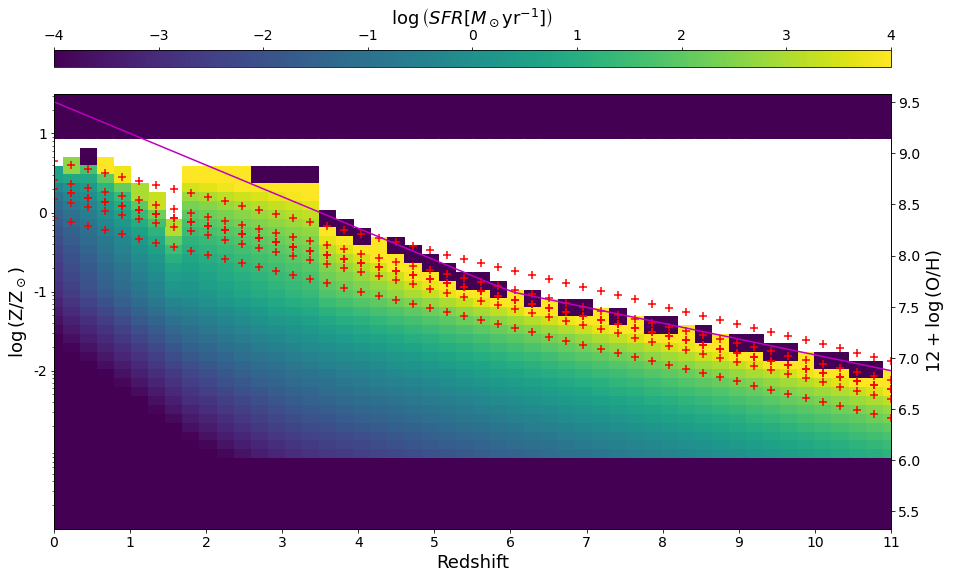

In [8]:
xx, yy1 = np.meshgrid(SFZRtest_z, SFZRtest_Z/ct.Z_SUN)
xx, yy2 = np.meshgrid(SFZRtest_z, SFZRtest_ZOH)

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(xx, yy1, c=testSFZRs.T, cmap='viridis', vmin=-1.707, vmax=2.003, s=270, marker='s')
ax.scatter(pick_plot[:,0], pick_plot[:,1], color='r', marker='+', s=50)
ax.plot(SFZRtest_z, Z_limits/ct.Z_SUN, 'm-')
ax.set_yscale('log')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=-4, vmax=4))
cb = fig.colorbar(sm, location='top', aspect=50)

ax.set_xlim(min(SFZRtest_z), max(SFZRtest_z))
ax.set_ylim(min(SFZRtest_Z/ct.Z_SUN), max(SFZRtest_Z/ct.Z_SUN))
ax.set_xlabel('Redshift', fontsize=18)
ax.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax.set_yticks([10**x for x in np.arange(-2.,2.,1.)])
ax.set_yticklabels([str(x) for x in np.arange(-2,2,1)])

ax.set_xticks(np.arange(0,12,1))

ax.tick_params(axis='both', labelsize=14)

ax2 = ax.twinx()

ax2.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax2.set_ylim(min(SFZRtest_ZOH), max(SFZRtest_ZOH))
ax2.tick_params(axis='both', labelsize=14)

cb.set_label(label=r'$\log\left(SFR[M_\odot\mathrm{yr}^{-1}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)